# Linear Regression
The purpose of this study is to learn about simple and multiple linear regression using both traditional methods and sklearn library. It assumes that there is a linear relation between the inputs $(x)$ and output $(y)$ as shown in the below formula.

$$\hat{y}= b_0 + b_1×x_1$$

First we'll calculate the weights using simple linear regression, then we'll do the same calculation using OLS and Gradient Descent.

We'll be using data from the TV Marketing study on [Kaggle](https://www.kaggle.com/datasets/devzohaib/tvmarketingcsv).

Eval their impact on the model.
    
Functions

OLS from previous study?

Gradient descent

## Table of Content

## Import Libraries

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)
import seaborn as sb
import math as m

In [2]:
df = pd.read_csv('Data/tvmarketing.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TV      200 non-null    float64
 1   Sales   200 non-null    float64
dtypes: float64(2)
memory usage: 3.2 KB


In [3]:
df.head()

,TV,Sales
0,230.1,22.1
1,44.5,10.4
2,17.2,9.3
3,151.5,18.5
4,180.8,12.9


## Assumptions
- **Linear Assumption.** Linear regression assumes that the relationship between your input and output is linear.
- **Remove Noise.** Linear regression assumes that your input and output variables are not noisy.
- **Remove Collinearity.** Linear regression will overfit your data when you have highly correlated input variables.
- **Gaussian Distributions.** Linear regression will make more reliable predictions if your input and output variables have a Gaussian distribution.
- **Rescale Inputs.** Linear regression will often make more reliable predictions if you rescale input variables using standardization or normalization.

<AxesSubplot: xlabel='TV', ylabel='Sales'>

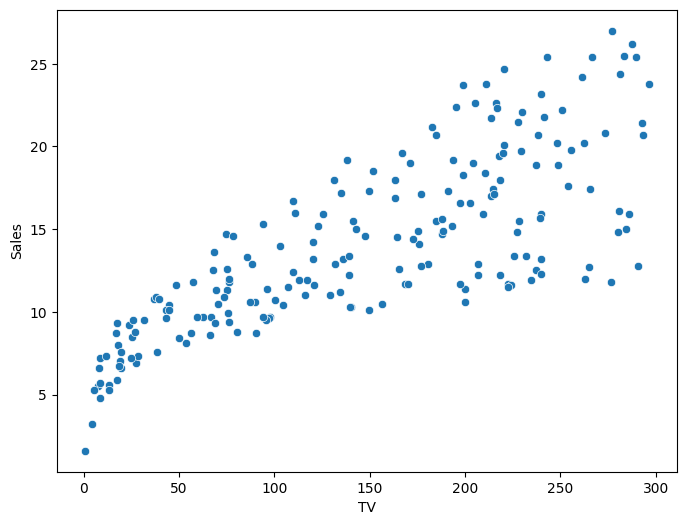

In [42]:
sb.scatterplot(data=df, x='TV', y='Sales')

In [5]:
x = df['TV']
y = df['Sales']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

# Training DataFrame
df_train = pd.DataFrame(columns=['TV', 'Sales'])
df_train['TV'] = x_train.reset_index(drop=True)
df_train['Sales'] = y_train.reset_index(drop=True)

# Testing DataFrame
df_test = pd.DataFrame(columns=['TV', 'Sales'])
df_test['TV'] = x_test.reset_index(drop=True)
df_test['Sales'] = y_test.reset_index(drop=True)

In [6]:
df_train.head()

,TV,Sales
0,67.8,12.5
1,139.5,10.3
2,96.2,11.4
3,18.8,7.0
4,76.4,11.8


## Finding the $\beta_1$

$$\beta_1 = \dfrac{\sum\limits_{i=1}^{n} ((x_i - mean(x) × (y_i - mean(y))}{\sum\limits_{i=1}^{n} (x_i - mean(x))^2}$$

In [7]:
mean_x = x_train.mean()
mean_x

149.43125

In [8]:
mean_y = y_train.mean()
mean_y

14.097500000000002

In [9]:
df_train['TV-mean_x'] = df_train['TV'] - mean_x
df_train['Sales-mean_y'] = df_train['Sales'] - mean_y

In [10]:
df_train.head()

,TV,Sales,TV-mean_x,Sales-mean_y
0,67.8,12.5,-81.63125,-1.5975
1,139.5,10.3,-9.93125,-3.7975
2,96.2,11.4,-53.23125,-2.6975
3,18.8,7.0,-130.63125,-7.0975
4,76.4,11.8,-73.03125,-2.2975


In [11]:
df_train['Mult'] = df_train['TV-mean_x'] * df_train['Sales-mean_y']
df_train.head()

,TV,Sales,TV-mean_x,Sales-mean_y,Mult
0,67.8,12.5,-81.63125,-1.5975,130.405922
1,139.5,10.3,-9.93125,-3.7975,37.713922
2,96.2,11.4,-53.23125,-2.6975,143.591297
3,18.8,7.0,-130.63125,-7.0975,927.155297
4,76.4,11.8,-73.03125,-2.2975,167.789297


In [12]:
sum_mult = df_train['Mult'].sum()
sum_mult

54102.9925

In [13]:
df_train['Squared'] = df_train['TV-mean_x'].pow(2)
df_train.head()

,TV,Sales,TV-mean_x,Sales-mean_y,Mult,Squared
0,67.8,12.5,-81.63125,-1.5975,130.405922,6663.660977
1,139.5,10.3,-9.93125,-3.7975,37.713922,98.629727
2,96.2,11.4,-53.23125,-2.6975,143.591297,2833.565977
3,18.8,7.0,-130.63125,-7.0975,927.155297,17064.523477
4,76.4,11.8,-73.03125,-2.2975,167.789297,5333.563477


In [14]:
sum_sq = df_train['Squared'].sum()
sum_sq

1159080.5037500001

In [15]:
b1 = sum_mult / sum_sq
b1

0.046677510599962065

## Finding $\beta_0$

$$\beta_0 = mean(y) − \beta_1 × mean(x)$$

In [16]:
b0 = mean_y - b1 * mean_x
b0

7.122421244159421

## Predicting

In [17]:
df_test['Pred'] = b0 + b1*df_test['TV']
df_test.head()

,TV,Sales,Pred
0,74.7,14.7,10.609231
1,255.4,19.8,19.043857
2,112.9,11.9,12.392312
3,109.8,16.7,12.247612
4,31.5,9.5,8.592763


### Calculating the Performance of Prediction
$$ RMSE = \sqrt{\frac{\sum\limits_{i=1}^{n} (p_i - y_i)^2}{n}} $$

In [18]:
df_test['error'] = df_test['Pred'] - df_test['Sales']
df_test.head()

,TV,Sales,Pred,error
0,74.7,14.7,10.609231,-4.090769
1,255.4,19.8,19.043857,-0.756143
2,112.9,11.9,12.392312,0.492312
3,109.8,16.7,12.247612,-4.452388
4,31.5,9.5,8.592763,-0.907237


In [19]:
df_test['sq_error'] = df_test['error'].pow(2)
df_test.head()

,TV,Sales,Pred,error,sq_error
0,74.7,14.7,10.609231,-4.090769,16.734389
1,255.4,19.8,19.043857,-0.756143,0.571752
2,112.9,11.9,12.392312,0.492312,0.242371
3,109.8,16.7,12.247612,-4.452388,19.823760
4,31.5,9.5,8.592763,-0.907237,0.823079


In [20]:
rmse = m.sqrt(df_test['sq_error'].sum() / len(df_test))
rmse

3.1663611501429614

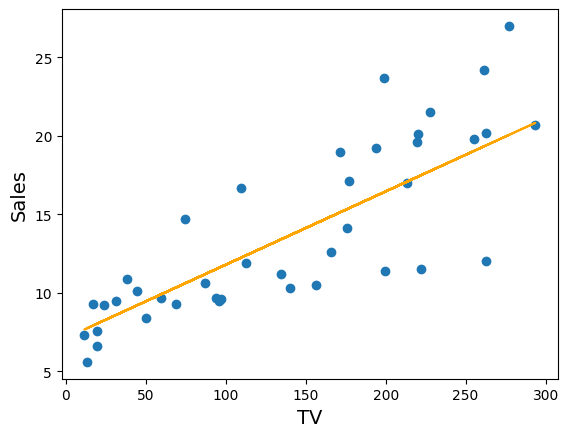

In [21]:
plt.scatter(df_test['TV'], df_test['Sales'])
fig = plt.plot(df_test['TV'], df_test['Pred'], c='orange', label='Regression Line')
plt.xlabel('TV', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.show()

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
x = df['TV']
y = df['Sales']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

# Training DataFrame
df_train = pd.DataFrame(columns=['TV', 'Sales'])
df_train['TV'] = x_train.reset_index(drop=True)
df_train['Sales'] = y_train.reset_index(drop=True)

# Testing DataFrame
df_test = pd.DataFrame(columns=['TV', 'Sales'])
df_test['TV'] = x_test.reset_index(drop=True)
df_test['Sales'] = y_test.reset_index(drop=True)

df_train.describe()

,TV,Sales
count,160.00000,160.000000
mean,149.43125,14.097500
std,85.38041,5.156811
min,0.70000,1.600000
25%,75.45000,10.675000
50%,150.65000,13.200000
75%,218.95000,17.325000
max,296.40000,26.200000


In [24]:
scaler = MinMaxScaler()
fit = scaler.fit(x_train.values.reshape(-1, 1))
x_train_scaled = fit.transform(x_train.values.reshape(-1, 1))
df_train['TV_Scaled'] = x_train_scaled
df_train.head()

,TV,Sales,TV_Scaled
0,67.8,12.5,0.226919
1,139.5,10.3,0.469395
2,96.2,11.4,0.322962
3,18.8,7.0,0.061211
4,76.4,11.8,0.256003


In [25]:
mean_x = df_train['TV_Scaled'].mean()
mean_y = df_train['Sales'].mean()

df_train['TV-mean_x'] = df_train['TV_Scaled'] - mean_x
df_train['Sales-mean_y'] = df_train['Sales'] - mean_y
df_train['Mult'] = df_train['TV-mean_x'] * df_train['Sales-mean_y']

sum_mult = df_train['Mult'].sum()
df_train['Squared'] = df_train['TV-mean_x'].pow(2)

sum_sq = df_train['Squared'].sum()
b1 = sum_mult / sum_sq
print('B1:', b1)

b0 = mean_y - b1 * mean_x
print('B0:', b0)


B1: 13.80253988440878
B0: 7.155095501579394


In [26]:
x_test_scaled = fit.transform(x_test.values.reshape(-1, 1))
df_test['TV_Scaled'] = x_test_scaled
df_test['Pred'] = b0 + b1*df_test['TV_Scaled']
df_test.head()

,TV,Sales,TV_Scaled,Pred
0,74.7,14.7,0.250254,10.609231
1,255.4,19.8,0.861346,19.043857
2,112.9,11.9,0.379439,12.392312
3,109.8,16.7,0.368955,12.247612
4,31.5,9.5,0.104160,8.592763


In [27]:
df_test['error'] = df_test['Pred'] - df_test['Sales']
df_test['sq_error'] = df_test['error'].pow(2)
rmse = m.sqrt(df_test['sq_error'].sum() / len(df_test))
rmse

3.1663611501429614

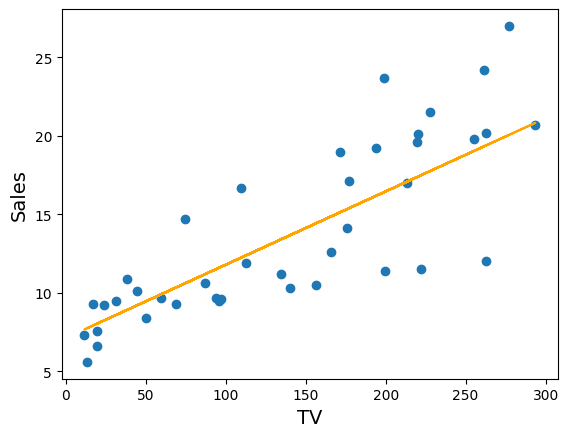

In [28]:
plt.scatter(df_test['TV'], df_test['Sales'])
fig = plt.plot(df_test['TV'], df_test['Pred'], c='orange', label='Regression Line')
plt.xlabel('TV', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.show()

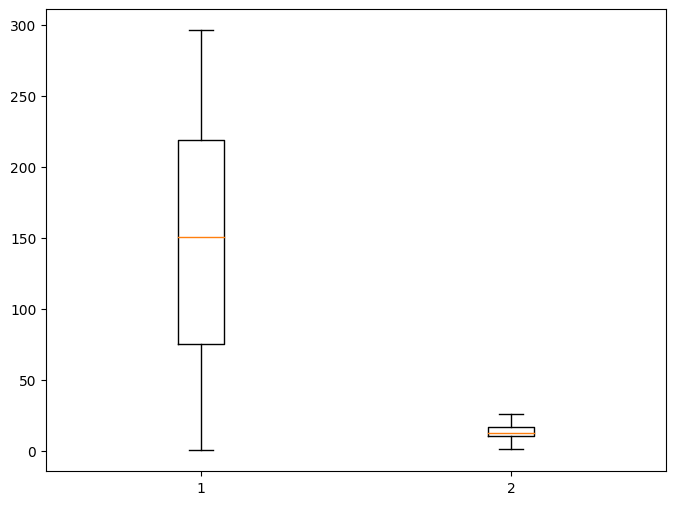

In [43]:
plt.boxplot(df_train[['TV', 'Sales']])
plt.show()

<AxesSubplot: xlabel='TV', ylabel='Count'>

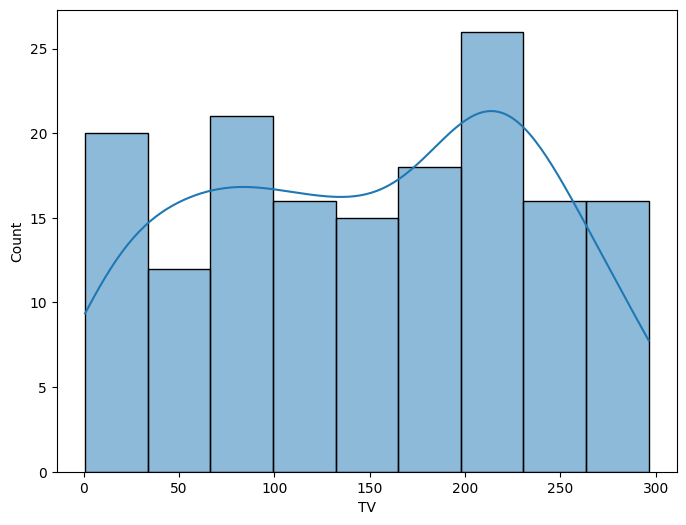

In [44]:
sb.histplot(data=df_train['TV'], kde=True)

<AxesSubplot: xlabel='Sales', ylabel='Count'>

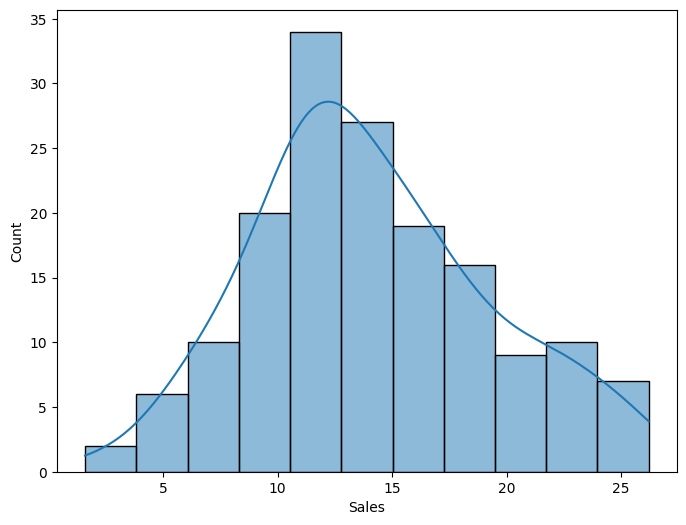

In [45]:
sb.histplot(data=df_train['Sales'], kde=True)